In [ ]:
from cv2 import imread, imwrite
from pyFusion.fusion import *
from pyFusion.legacy.image_fusion_tool import Image_fusion_tool
from pyFusion.models.vgg19 import VGG19
from pyFusion.models.squeezeNet import Squeeze
from pyFusion import metrics
from torch import device
from torch.cuda import is_available

import matplotlib.pyplot as plt


In [ ]:

# Parse arguments
images_path = ['images/MRI-CT/ct.png', 'images/MRI-CT/mr.png']
output = 'results/MRI-CT/'

# Read images
input_images = []
for image in images_path:
    input_images.append(imread(image))

In [ ]:

device = device("cuda" if is_available() else "cpu")
model = VGG19(device)
#model = Squeeze(device)

FU = Fusion(input_images, model)
fused_image = FU.fuse()

In [ ]:
#imwrite("fusion", fused_image.astype('uint8'))
#plt.imshow(fused_image, cmap='gray')

In [ ]:
# Read images

images_path = ['images/MRI-CT/ct.png', 'images/MRI-CT/mr.png']
output = 'results/MRI-CT/'
images = []
for image in images_path:
    images.append(imread(image,0))
im0 = images[0]
im1 = images[1]

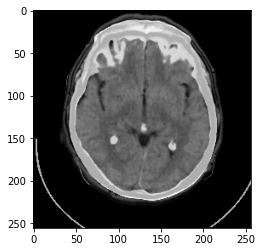

In [12]:
#fused_image = imread('/mnt/0CDA4207DA41EE10/Cristian/Immagini/Tesi/ImageFusionWavelets/MRI-CT.jpg', 0)
#fused_image = imread('/mnt/0CDA4207DA41EE10/Cristian/Immagini/Tesi/ImageFusionVisualSaliency/MRI-CT/fused.jpg', 0)
f = Image_fusion_tool('output')
#fused_image = f.pyramid_image_fusion(im0, im1, 'weighted')
#fused_image = f.weighted_average_fusion(im0,im1,0.7,0.3)
#fused_image = f.HSI_image_fusion(images[0],images[1]) # solo per immagini a colori
#fused_image = f.PCA_image_fusion(im0, im1)
fused_image = f.PCA_fusion(im0, im1)


plt.imshow(fused_image, cmap='gray')
# imwrite(output+'PCA_MRI-CT.jpg', fused_image)
# fused_img = np.clip(fused_image, 0, 1)
fused_image =(fused_image * 255).astype(np.uint8)

In [13]:
metrics.xydeas_petrovic_metric(im0, im1, fused_image)

0.7427249957819568

In [14]:
metrics.xydeas_petrovic_total_fusion_gain(im0, im1, fused_image)

0.477707142159551

In [15]:
metrics.xydeas_petrovic_fusion_loss(im0, im1, fused_image)

0.0

In [16]:
mse0 = metrics.mean_squared_error(im0, fused_image) 
mse1 = metrics.mean_squared_error(im1, fused_image) 
mean_mse = (mse0 + mse1) / 2
mean_mse  

5398.890182495117

In [17]:
en0 = metrics.entropy_2d(im0, fused_image)
en1 = metrics.entropy_2d(im1, fused_image)
mean_entropy = (en0 + en1) / 2
mean_entropy


3.4958328592143944

In [18]:
mi0 = metrics.mutual_information_2d(im0, fused_image)
mi1 = metrics.mutual_information_2d(im1, fused_image)
mean_mi = (mi0 + mi1) / 2
mean_mi

1.4781262255772507

In [21]:
ssim0 = metrics.ssim(im0, fused_image)
ssim1 = metrics.ssim(im1, fused_image)
mean_ssim = (ssim0 + ssim1) / 2
mean_ssim

0.4108946573167692

In [20]:
d0 = metrics.discrepancy(im0, fused_image)
d1 = metrics.discrepancy(im1, fused_image)
mean_discrepancy = (d0 + d1) / 2
mean_discrepancy

4390719.0